<a href="https://colab.research.google.com/github/satrio-hw/probabilistic-programming--DataMining/blob/master/tugas4_0102517023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining

## Tugas 4: Bayesian Statistics

### Mekanisme

Anda hanya diwajibkan untuk mengumpulkan file ini saja ke uploader yang disediakan di http://elearning.uai.ac.id/. Ganti nama file ini saat pengumpulan menjadi **tugas4_NIM.ipynb**.

**Keterlambatan**: Pengumpulan tugas yang melebihi tenggat yang telah ditentukan tidak akan diterima. Keterlambatan akan berakibat pada nilai nol untuk tugas ini.

**Kolaborasi**: Anda diperbolehkan untuk berdiskusi dengan teman Anda, tetapi *dilarang keras* menyalin kode maupun tulisan dari teman Anda.

### Petunjuk

Terdapat beberapa *packages* yang Anda akan gunakan dalam mengerjakan tugas ini, yaitu:

- matplotlib
- numpy
- pandas
- pymc3
- scipy
- seaborn
- scikit-learn

Anda diperbolehkan (jika dirasa perlu) untuk mengimpor modul tambahan untuk tugas ini, kecuali dijelaskan sebaliknya. Namun, seharusnya modul yang tersedia sudah cukup untuk memenuhi kebutuhan Anda.

Pastikan jawaban Anda singkat, padat, dan jelas. Mayoritas pertanyaan yang diberikan dapat dijawab dalam 3-4 kalimat saja.

### Import

In [1]:
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
!pip install arviz
import arviz as az
%matplotlib inline

RANDOM_STATE = 1945
plt.style.use('bmh')

## 1. Memodelkan Kemampuan Petinju (15 poin)

Dua orang petinju, MP dan ODLH, akan bertemu satu masing-masing dalam sebuah pertandingan amal. MP telah bertanding 70 kali dan memenangkan 61 pertandingan, sedangkan ODLH menang 39 kali dari 45 pertandingannya. Asumsikan bahwa Anda tidak tahu apapun tentang kemampuan kedua petinju ini awalnya, lalu Anda ingin memodelkan peluang MP akan menang dari ODLH.

### Soal 1.1 (2 poin)

Jika Anda memodelkan kemampuan (skill) MP dan ODLH sebagai distribusi beta, berapa nilai parameter dari masing-masing model?

**Parameter yang digunakan untuk Beta distribution adalah <br>$\alpha$ = $\beta$ = 1<br> karena tidak diketahui informasi apapun pada prior tentang skill kedua petinju**

In [2]:
with pm.Model() as skill:
    p_MP = pm.Beta('win_rate_MP', alpha=1, beta=1) #beta as prior MP
    win_MP = pm.Binomial('win_MP', n=70, p=p_MP, observed=61)
    
    p_ODLH = pm.Beta('win_rate_ODLH', alpha=1, beta=1) #beta as prior ODLH
    win_ODLH = pm.Binomial('win_ODLH', n=45, p=p_ODLH, observed=39)
    
    diff = pm.Deterministic('diff', p_MP - p_ODLH)
    
    traceall = pm.sample(5000, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [win_rate_ODLH, win_rate_MP]
100%|██████████| 7500/7500 [00:06<00:00, 1176.55it/s]


/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


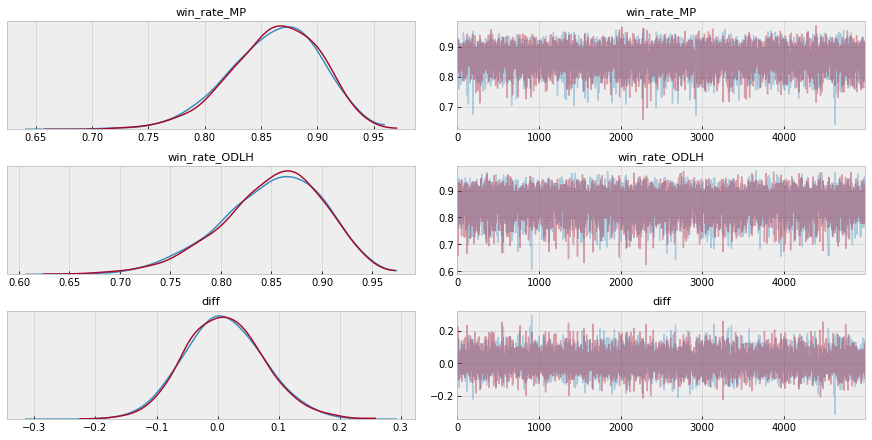

In [3]:
pm.traceplot(traceall);

In [4]:
print('P(win_{MP}) = %f' % ((traceall['win_rate_MP']).mean()))
print('P(win_{ODLH}) = %f' % ((traceall['win_rate_ODLH']).mean()))
print('P(diff)) = %f' % ((traceall['diff']).mean()))

P(win_{MP}) = 0.861879
P(win_{ODLH}) = 0.850739
P(diff)) = 0.011140


### Soal 1.2 (2 poin)

Gambarkan distribusi dari "skill" kedua petinju.

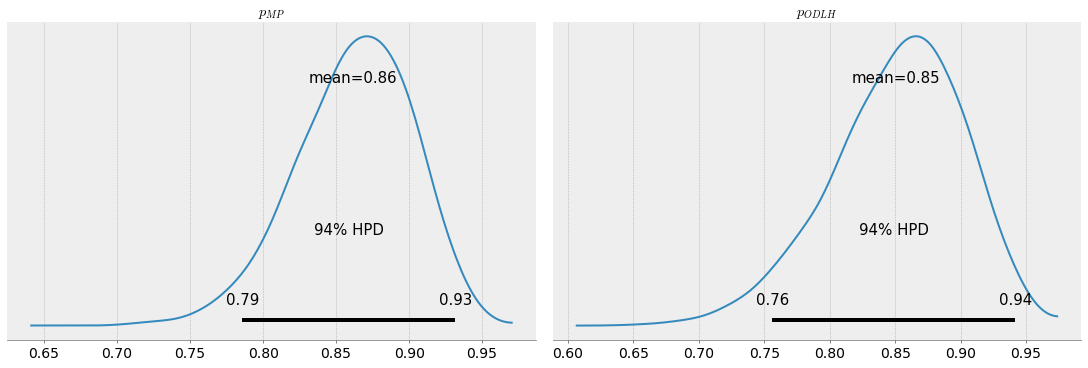

In [5]:
ax = pm.plot_posterior(traceall, var_names=['win_rate_MP', 'win_rate_ODLH'], figsize=(15,5))
ax[0].set_title('$p_{MP}$')
ax[1].set_title('$p_{ODLH}$');

### Soal 1.3.a (4 poin)

Berapa nilai ekspektasi dan variansi dari kedua model?

**Expected Value (EV) adalah rata-rata posterior yang didapat dari kedua model diatas:**

In [6]:
print('E(win_{MP}) = %f' % ((traceall['win_rate_MP']).mean()))
print('E(win_{MP}) = %f' % ((traceall['win_rate_ODLH']).mean()))

E(win_{MP}) = 0.861879
E(win_{MP}) = 0.850739


**dan variance terhadap kedua EV tersebut adalah:**

In [7]:
print('Variance(win_{MP}) = %f' % ((traceall['win_rate_MP']).var()))
print('Variance(win_{MP}) = %f' % ((traceall['win_rate_ODLH']).var()))

Variance(win_{MP}) = 0.001602
Variance(win_{MP}) = 0.002582


### Soal 1.3.b (2 poin)

Berdasarkan ekspektasi tersebut, siapa petinju yang lebih baik?

*Jawaban Anda di sini*
<br>**MP memiliki EV lebih tinggi (86,18%) dibandingkan ODLH (85,07%), sehingga MP mungkin lebih baik dibandingkan ODLH dengan confidence 44,5% hingga 55,5%**

### Soal 1.4 (5 poin)

Hitunglah peluang PM akan menang melawan ODLH.

/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd414a3710>],
      dtype=object)

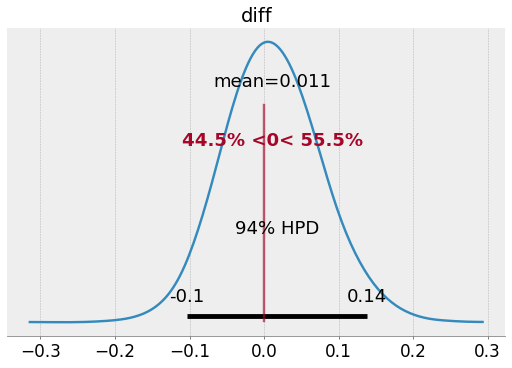

In [8]:
pm.plot_posterior(traceall, varnames=['diff'], ref_val=0, figsize=(7,5))

In [9]:
(pm.trace_to_dataframe(traceall)).describe()

,win_rate_MP,win_rate_ODLH,diff
count,10000.000000,10000.000000,10000.000000
mean,0.861879,0.850739,0.011140
std,0.040030,0.050813,0.064619
min,0.641186,0.606685,-0.314258
25%,0.836798,0.819223,-0.033178
50%,0.865187,0.855705,0.009128
75%,0.890631,0.887116,0.053117
max,0.970277,0.973733,0.293054


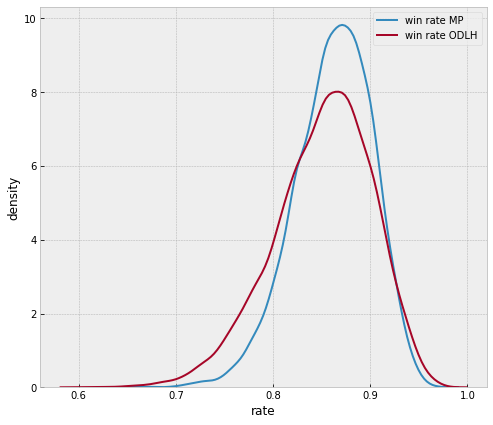

In [10]:
fig, ax = plt.subplots(figsize=(8,7))
sns.distplot(traceall['win_rate_MP'], hist=False, label='win rate MP')
sns.distplot(traceall['win_rate_ODLH'], hist=False, label='win rate ODLH')
plt.xlabel('rate')
plt.ylabel('density');

**Dengan Expected Value dari selisih kedua kemungkinan menang kedua petinju, <br>$EV(diff)=0.011140$ $|\equiv|$ 1.11% <br>
Peluang PM menang atas ODLH sebesar 44,5% hingga 55,5%**

## 2. Perbandingan Tinggi Badan (5 poin)

Asumsikan ada dua kelompok orang yang ingin Anda bandingkan tinggi badannya seperti pada contoh kode di bawah ini.

In [0]:
from scipy.stats import norm

np.random.seed(42)

height_a = [
    170., 164., 171., 180., 163., 163., 181., 173., 160., 170., 160.,
    160., 167., 146., 148., 159., 155., 168., 156., 151.
]
height_b = [
    150., 153., 144., 143., 163., 169., 154., 165., 159., 149., 159.,
    170., 155., 171., 129., 163., 156., 152., 156., 135., 153., 159.,
    170., 150., 147., 150., 164., 158., 150., 160., 156., 165., 148.,
    152., 151., 140., 158., 158., 155., 153.
]

Buatlah model Bayesian dari selisih antara rata-rata tinggi badan kelompok A dan kelompok B. Gambarkan trace plot dan posterior plotnya.

data in group A :  20
data in group B :  40


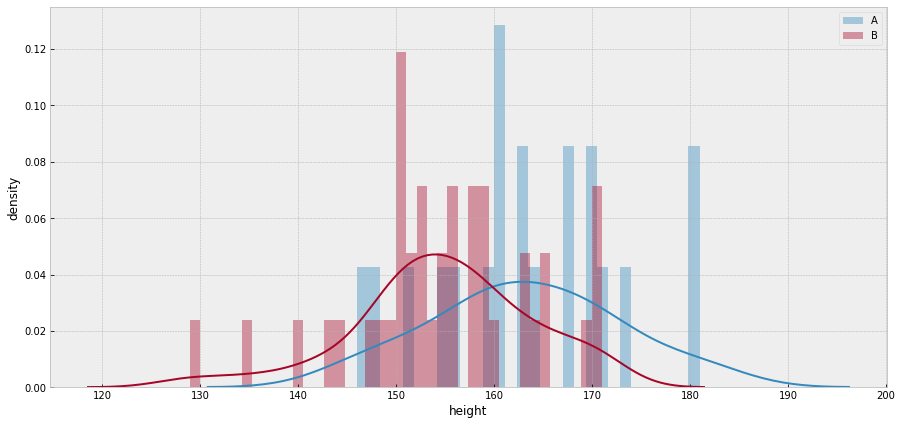

In [0]:
# kode Anda di sini
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(height_a, bins=30, label='A',hist=True)
sns.distplot(height_b, bins=40, label='B', hist=True)
plt.xlabel('height')
plt.ylabel('density')
plt.legend();

print("data in group A : ",len(height_a));
print("data in group B : ",len(height_b));

In [0]:
with pm.Model() as model_no2:
    # kode Anda di sini
    p_heightA = pm.Beta('prior_a', alpha=1, beta=1) #prior height A
    solved_heightA = pm.Binomial('hA', n=20, p=p_heightA, observed=20)
    
    p_heightB = pm.Beta('prior_b', alpha=1, beta=1) #prior height B
    solved_heightB = pm.Binomial('hB', n=40, p=p_heightB, observed=40)
    
    diff = pm.Deterministic('diff', p_heightB - p_heightA)
    
    trace_modelno2 = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior_b, prior_a]
100%|██████████| 10500/10500 [00:08<00:00, 1296.55it/s]


In [0]:
pm.summary(trace_modelno2)

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
prior_a,0.954656,0.043533,0.000371,0.866622,0.999999,13869.177131,0.999987
prior_b,0.976150,0.023694,0.000217,0.928372,0.999996,13636.484160,0.999953
diff,0.021494,0.049401,0.000421,-0.068690,0.129160,14009.443139,0.999988


/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


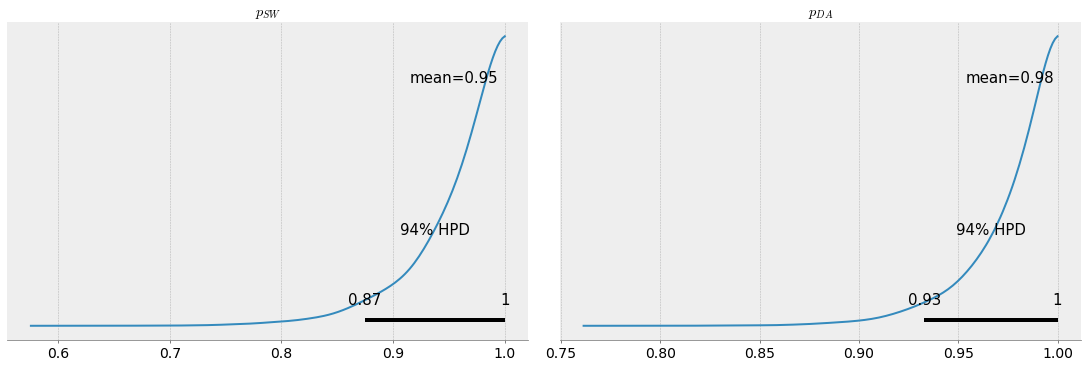

In [0]:
ax = pm.plot_posterior(trace_modelno2, varnames=['prior_a', 'prior_b'], figsize=(15,5))
ax[0].set_title('$p_{SW}$')
ax[1].set_title('$p_{DA}$');

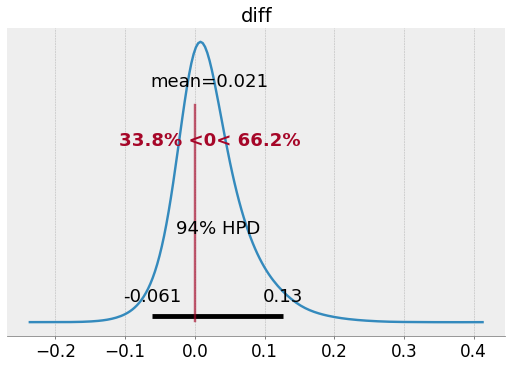

In [0]:
pm.plot_posterior(trace_modelno2, var_names=['diff'], ref_val=0, figsize=(7,5));

In [0]:
display(HTML(
    '$P(p_{SW} > p_{DA}) = %.5f$' % ((trace_modelno2['diff'] > 0).mean())
))